<a href="https://colab.research.google.com/github/BeccaOY/BeccaOY/blob/main/Customer_Subscription_Status_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BUSINESS OBJECTIVE: 
- Train a model to predict customers who will unsubscribe in July 2018



BUSINESS HYPOTHESES: 
Customers who unsubcribe are likely...
- Received too many emails
- Acquired recently
- Not as engaged 
	- less store visit
	- less email open & click
	- spend less
	- shop in fewer product areas
	- no dillards' credit card
- Live further from store


LOAD IN DATA WITH PANDAS

In [27]:
import pandas as pd
import numpy as np

sub_status = pd.read_csv('customer_subscription_status.csv')
email_activity = pd.read_csv('customer_email_campaign_agg.txt')
customer_info = pd.read_csv('customer.txt')
store_location= pd.read_csv('store_location.txt')
purchase_info = pd.read_csv('transaction_detail.txt')
items = pd.read_csv('item.txt')

## FEATURE ENGINEERING

In [28]:
#perform feature engineering by recoding y, n to 0,1
def recode(series):
    if series == 'N':
      return 1
    if series == 'Y':
      return 0
sub_status['unsubscribed_yn'] = sub_status['unsubscribed_yn'].apply(recode)

In [29]:
#perform feature engineering by recoding y, n to 0,1
def recode(series):
    if series == 'N':
      return 0
    if series == 'Y':
      return 1
customer_info['household_has_dillards_credit_card'] = customer_info['household_has_dillards_credit_card'].apply(recode)

BREAK DOWN DIFFERENT DATASETS TO INCLUDE ONLY RELEVANT COLUMNS

In [30]:
from numpy.core.fromnumeric import product
Target = sub_status['unsubscribed_yn']
email_engagement = email_activity[['total_email_sent_count', 'total_email_click_count', 'total_email_open_count']]
customer_details = customer_info[['customer_contact_acquisition_date', 'household_has_dillards_credit_card','household_distance_to_nearest_store']]
transactions = purchase_info[['netSpend','customer_id','item_id']]
products = items[['item_id','product_category']]


In [31]:
Target.tail(50)

24950    0
24951    0
24952    0
24953    0
24954    0
24955    0
24956    0
24957    0
24958    0
24959    0
24960    0
24961    0
24962    0
24963    0
24964    0
24965    0
24966    0
24967    0
24968    0
24969    0
24970    0
24971    0
24972    0
24973    0
24974    0
24975    0
24976    0
24977    0
24978    0
24979    0
24980    0
24981    0
24982    0
24983    0
24984    0
24985    0
24986    0
24987    0
24988    0
24989    0
24990    0
24991    0
24992    0
24993    0
24994    0
24995    0
24996    0
24997    0
24998    0
24999    0
Name: unsubscribed_yn, dtype: int64

In [32]:
purchases = pd.merge(transactions,products, on = 'item_id')
customer_by_product_areas = pd.DataFrame(purchases.groupby('customer_id')['product_category'].count())
customer_by_product_areas

,product_category
customer_id,
115614798,18
115626104,25
115626867,5
115627422,5
115627578,1
...,...
226645567,1
226646215,1
226647569,2


In [33]:
#get number of visits

from pandas.core.algorithms import value_counts
visit_frequency = pd.DataFrame(purchase_info.customer_id.value_counts())
visit_frequency


,customer_id
168362845,628
218917163,516
216353708,489
223779446,420
221036205,409
...,...
224404887,1
119319942,1
223382914,1
225587052,1


In [34]:
#get average spend amount
average_spend = pd.DataFrame(transactions.groupby('customer_id')['netSpend'].mean())

In [35]:
#Remove unknown values
customer_details_new = customer_details.replace("?", np.nan)
customer_details_new.count()
customer_details_new

,customer_contact_acquisition_date,household_has_dillards_credit_card,household_distance_to_nearest_store
0,11/3/2017,0,NaN
1,2/17/2018,1,NaN
2,5/15/2018,0,NaN
3,12/23/2017,0,NaN
4,9/19/2013,0,4.708
...,...,...,...
24995,7/27/2018,0,27.048
24996,12/3/2017,0,NaN
24997,9/10/2016,0,5.913
24998,2/5/2009,1,11.486


CREATE ONE DATAFRAME WITH ALL FEATURES AND LABEL

In [36]:
#add all datasets as a list
datasets = [email_engagement,visit_frequency,average_spend,customer_by_product_areas,customer_details_new,Target]

In [37]:
#merge datasets
dataset_1 = pd.concat(datasets, join='outer', axis=1).fillna(0)
dataset_1

,total_email_sent_count,total_email_click_count,total_email_open_count,customer_id,netSpend,product_category,customer_contact_acquisition_date,household_has_dillards_credit_card,household_distance_to_nearest_store,unsubscribed_yn
0,55.0,0.0,16.0,0.0,0.00,0.0,11/3/2017,0.0,0,1.0
1,29.0,1.0,3.0,0.0,0.00,0.0,2/17/2018,1.0,0,1.0
2,24.0,0.0,0.0,0.0,0.00,0.0,5/15/2018,0.0,0,1.0
3,22.0,0.0,0.0,0.0,0.00,0.0,12/23/2017,0.0,0,1.0
4,2.0,0.0,1.0,0.0,0.00,0.0,9/19/2013,0.0,4.708,1.0
...,...,...,...,...,...,...,...,...,...,...
226645567,0.0,0.0,0.0,1.0,16.00,1.0,0,0.0,0,0.0
226646215,0.0,0.0,0.0,1.0,130.00,1.0,0,0.0,0,0.0
226647569,0.0,0.0,0.0,2.0,46.44,2.0,0,0.0,0,0.0
226653022,0.0,0.0,0.0,1.0,27.99,1.0,0,0.0,0,0.0


SPLIT DATA 

In [38]:
x = dataset_1[['total_email_sent_count', 'total_email_click_count', 'total_email_open_count', 'netSpend', 'product_category', 'household_has_dillards_credit_card','household_distance_to_nearest_store']]
y = dataset_1['unsubscribed_yn']

In [39]:
# # Create our imputer to replace missing values with the mean

# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp = imp.fit(x_train)
# x_train_imp = imp.transform(x_train)
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp = imp.fit(x_test)
# x_test_imp = imp.transform(x_test)

In [40]:
#split data to use a test set to evaluate the performance of the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .33)

In [41]:
from sklearn.linear_model import LogisticRegression
#set regularization hyperparameter to counteract bais, generalize and avoid overfitting
reg = .01
model = LogisticRegression(C=1/reg,solver='liblinear').fit(x_train,y_train)
print(model)

LogisticRegression(C=100.0, solver='liblinear')


EVALUATE MODEL

In [42]:
prediction = model.predict(x_test)
prediction

array([1., 0., 0., ..., 1., 0., 0.])

CHECK ACCURACY

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(y_test, prediction)
print('Accuracy Score: ', accuracy_score)

Accuracy Score:  0.9080909151149692


THE MODEL IS 91% ACCURATE AT PREDICTING SUBSCRIPTION STATUS



### Classification Report

In [44]:
from sklearn. metrics import classification_report

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91      8384
         1.0       0.83      1.00      0.91      6707

    accuracy                           0.91     15091
   macro avg       0.91      0.92      0.91     15091
weighted avg       0.92      0.91      0.91     15091



Precision basically shows how many of the instances were correctly classified. Of all customers that remained subscribed, how many did the model classify as such?

Recall determines what number of the instances were identified in each class. Of all customers that remained subscribed, how many were actualy identified by the model?

F1 score is basically an average metric involving precision and recall

Support provides the total number for each class in the test set.


In [45]:
#this focuses on the positive outcome alone, i.e remained subscribed
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, prediction))
print("Overall Recall:",recall_score(y_test, prediction))

Overall Precision: 0.8286384976525821
Overall Recall: 1.0


The precision and recall metrics are derived from four possible prediction outcomes:
True Positives: The predicted label and the actual label are both 1.
False Positives: The predicted label is 1, but the actual label is 0.
False Negatives: The predicted label is 0, but the actual label is 1.
True Negatives: The predicted label and the actual label are both 0.

In [52]:
#To illustrate the above
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, prediction)
print (cm)

[[6997 1387]
 [   0 6707]]


All true positives were correctly classified by the model!

In [61]:
# convert classifications into actual probablities for 0 and 1 given a threshold of 0.5
y_scores = model.predict_proba(x_test)
y_scores

array([[4.43722573e-01, 5.56277427e-01],
       [9.99868604e-01, 1.31395949e-04],
       [1.00000000e+00, 1.06595011e-19],
       ...,
       [2.29545651e-02, 9.77045435e-01],
       [1.00000000e+00, 4.05688226e-24],
       [9.99887678e-01, 1.12321503e-04]])

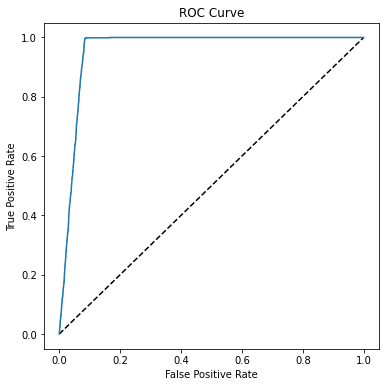

In [63]:
#Using above probabilities to plot a received operator characteristic chart to measure how different thresholds affect predictions
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

A perfect classifier would have a curve that goes straight up the left side and straight across the top.
So the model is not far off!

In [64]:
#The area under the curve (AUC) is a value between 0 and 1 that quantifies the overall performance of the model. 
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ', auc)

AUC:  0.9591042922428088


# SAVE MODEL FOR FUTURE USE

In [51]:
import joblib

# Save the model as a pickle file
filename = './unsubscribe_model.pkl'
joblib.dump(model, filename)

['./unsubscribe_model.pkl']